In [1]:
# !unzip "/content/individual_stocks_5yr.zip" -d "/content"
folder_dir = "./individual_stocks_5yr"

In [1]:
import os
import pandas as pd
import numpy as np

import tensorflow as tf
keras = tf.keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras import layers

import matplotlib.pyplot as plt

In [2]:
# Pick one stock
dir = "./individual_stocks_5yr/AAPL_data.csv"
df = pd.read_csv(dir)
change = np.array(df['close'] - df['open'])
close_price = np.array(df['close'])
close_price[:20]

array([67.8542, 68.5614, 66.8428, 66.7156, 66.6556, 65.7371, 65.7128,
       64.1214, 63.7228, 64.4014, 63.2571, 64.1385, 63.5099, 63.0571,
       61.4957, 60.0071, 61.5919, 60.8088, 61.5117, 61.6742])

In [29]:
#Given day_shift, get data and data_split
def process_data(day_shift):
    previous_days = np.zeros((len(close_price)-day_shift, day_shift))
    for i in range(len(close_price)-day_shift):
        previous_days[i] = close_price[i:i+day_shift]

    previous_days = previous_days[..., np.newaxis]
    target = close_price[day_shift:]

    split_percent = 0.8
    valid_test_percent = 0.5
    N = target.shape[0]

    split_index_1 = int(N*split_percent)

    X_train, y_train = previous_days[:int(N*split_percent)], target[:int(N*split_percent)]
    X_valid_test, y_valid_test = previous_days[int(N*split_percent):], target[int(N*split_percent):]

    split_index_2 = int(y_valid_test.shape[0] * valid_test_percent) + split_index_1
    X_valid, y_valid = previous_days[split_index_1:split_index_2], target[split_index_1:split_index_2]
    X_test, y_test = previous_days[split_index_2:], target[split_index_2:]
    
    return X_train, y_train, X_valid, y_valid, X_test, y_test
    

In [23]:
# Plot sample
def plot_data(day_shift):
    X_train, y_train, X_valid, y_valid, X_test, y_test = process_data(day_shift)

    split_index_1 = len(X_train)
    split_index_2 = split_index_1 + len(X_valid)
    N = split_index_2 + len(X_test)
    day = np.arange(0, N)
    plt.figure(figsize=(12,4))
    plt.plot(day[:split_index_1], y_train)
    plt.plot(day[split_index_1:split_index_2], y_valid)
    plt.plot(day[split_index_2:], y_test)
    plt.legend(['Train', 'Valid', 'Test'])
    plt.show()

In [32]:
'''
parameters
'''
def train_predict_model(lr=0.001, epoch=200, day_shift=7, verbose = 0):
    
    X_train, y_train, X_valid, y_valid, X_test, y_test = process_data(day_shift)
    
    model = Sequential()

    model.add(layers.Input((day_shift, 1)))
    model.add(layers.LSTM(128))
    model.add(layers.Dense(64))
    model.add(layers.LeakyReLU(alpha=lr))
    model.add(layers.Dense(32))
    model.add(layers.LeakyReLU(alpha=lr))
    model.add(layers.Dense(1, activation='linear'))

    model.compile(loss='mse', 
              optimizer=Adam(learning_rate=lr),
              metrics=['mean_absolute_error'])

    history = model.fit(X_train, y_train, 
                    validation_data=(X_valid, y_valid),
                    epochs = epoch, verbose=verbose)

    score = model.evaluate(X_valid, y_valid, verbose=0)
    #print('Validation loss:', np.sqrt(score[0]))
    #print('Mean absolute error:', score[1])
    return model, np.sqrt(score[0]), score[1], history #model, rmse, mean absolute error, history

In [26]:
def plot_results(history):
    plt.figure(figsize=(12,4))
    plt.plot(history.history['mean_absolute_error'])
    plt.plot(history.history['val_mean_absolute_error'])
    plt.title('mean absolute error')
    plt.ylabel('mean absolute err')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()

    plt.figure(figsize=(12,4))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.ylim((0,2500))
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()

In [31]:
# Find best learning rate/day_shift combo
learning_rates = [0.0001, 0.0005, 0.001, 0.005, 0.01]
day_shifts = np.arange(1, 8)
results = []
for rate in learning_rates:
    for day_shift in day_shifts:
        model, val_loss, mae, history = train_predict_model(lr=rate, epoch=100, day_shift = day_shift)
        results.append((rate, day_shift, val_loss))

for result in results:
    print("lr: " + str(result[0]) + ', day_shift: ' + str(result[1]) + " - rmse: " + str(result[2]))

lr: 0.0001, day_shift: 1 - rmse: 11.219924397749342
lr: 0.0001, day_shift: 2 - rmse: 11.563998398476235
lr: 0.0001, day_shift: 3 - rmse: 13.732455070584612
lr: 0.0001, day_shift: 4 - rmse: 13.991984661427592
lr: 0.0001, day_shift: 5 - rmse: 13.077982073405082
lr: 0.0001, day_shift: 6 - rmse: 12.562368211956432
lr: 0.0001, day_shift: 7 - rmse: 13.892026609545221
lr: 0.0005, day_shift: 1 - rmse: 5.1904540326040065
lr: 0.0005, day_shift: 2 - rmse: 9.937020536168298
lr: 0.0005, day_shift: 3 - rmse: 12.541220487006475
lr: 0.0005, day_shift: 4 - rmse: 11.313232060977418
lr: 0.0005, day_shift: 5 - rmse: 11.08854720923466
lr: 0.0005, day_shift: 6 - rmse: 11.272926197366393
lr: 0.0005, day_shift: 7 - rmse: 10.175188922299782
lr: 0.001, day_shift: 1 - rmse: 7.003182913707992
lr: 0.001, day_shift: 2 - rmse: 11.431891395090343
lr: 0.001, day_shift: 3 - rmse: 11.335611077097298
lr: 0.001, day_shift: 4 - rmse: 12.568800527659812
lr: 0.001, day_shift: 5 - rmse: 11.49217023919506
lr: 0.001, day_shift:

In [33]:
#Best parameters
lr = 0.0005
day_shift = 1

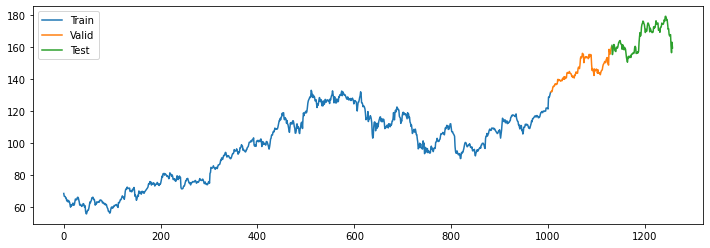

In [34]:
#data plot
plot_data(day_shift)

In [35]:
X_train, y_train, X_valid, y_valid, X_test, y_test = process_data(day_shift)
model, rmse, mae, history = train_predict_model(lr=lr, epoch=500, day_shift = day_shift)

32/32 [==============================] - 0s 3ms/step


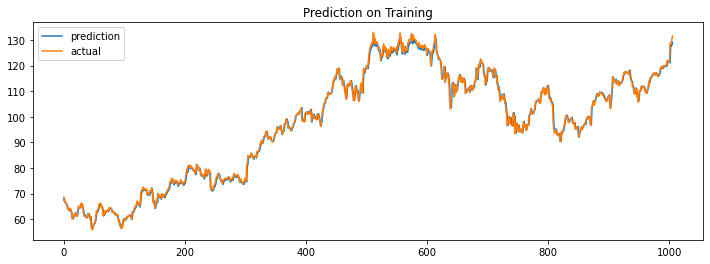

In [36]:
# Show Prediction on Training
prediction = model.predict(X_train).flatten()

plt.figure(figsize=(12,4))
plt.plot(prediction)
plt.plot(y_train)
plt.title("Prediction on Training")
plt.legend(['prediction','actual'])

4/4 [==============================] - 0s 2ms/step


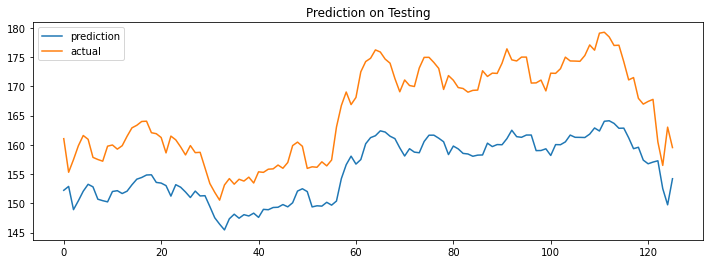

In [37]:
# Show Prediction on Testing
prediction = model.predict(X_test).flatten()

plt.figure(figsize=(12,4))
plt.plot(prediction)
plt.plot(y_test)
plt.title("Prediction on Testing")
plt.legend(['prediction','actual'])

In [38]:
print('model rmse: ' + str(rmse))

model rmse: 4.7110103772348095
